In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.manifold import TSNE



In [15]:

import lightgbm as lgb
import optuna #Optuna is an automatic hyperparameter optimization software framework, particularly designed for machine learning.
from optuna.samplers import TPESampler
import pickle

In [7]:
import matplotlib.pyplot as plt

In [4]:
train_data = pd.read_csv('train_data_swc.csv')
test_data = pd.read_csv('test_data_swc.csv')
example_data = pd.read_csv('example.csv')

In [4]:
print('number of data points in the train data: ' , len(train_data))
print('number of data points in the test data: ' , len(test_data))

number of data points in the train data:  62500
number of data points in the test data:  150000


In [4]:
train_data.head(5)

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,x_100,x_101,x_102,x_103,x_104,x_105,x_106,x_107,x_108,y
0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,3
1,0.2,0.8,0.0,0.0,0.0,0.0,0.6,0.2,0.0,0.0,...,0.2,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,9
2,0.0,0.0,0.0,0.4,0.0,0.0,3.2,0.0,0.0,0.0,...,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,3
3,0.0,0.0,0.2,0.0,0.0,0.0,0.2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.4,0.0,0.0,0.0,0.4,0.0,0.0,0.6,...,0.0,0.0,0.0,0.6,0.2,0.0,0.0,0.2,0.0,9


In [6]:
test_data.head(5)

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,x_99,x_100,x_101,x_102,x_103,x_104,x_105,x_106,x_107,x_108
0,0.0,0.0,0.0,0.0,0.0,0.0,1.8,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.4,0.2,0.0,0.0,0.0,...,0.0,0.0,0.6,0.0,0.0,0.2,0.0,0.0,0.2,0.0
2,0.2,0.0,0.2,0.0,0.0,0.0,0.4,0.0,0.4,0.4,...,0.0,0.0,0.2,0.0,0.0,0.0,0.6,0.0,0.0,4.4
3,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.2,0.0,2.8,0.0,0.2,0.0,0.0,0.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2


## Correlation among Features

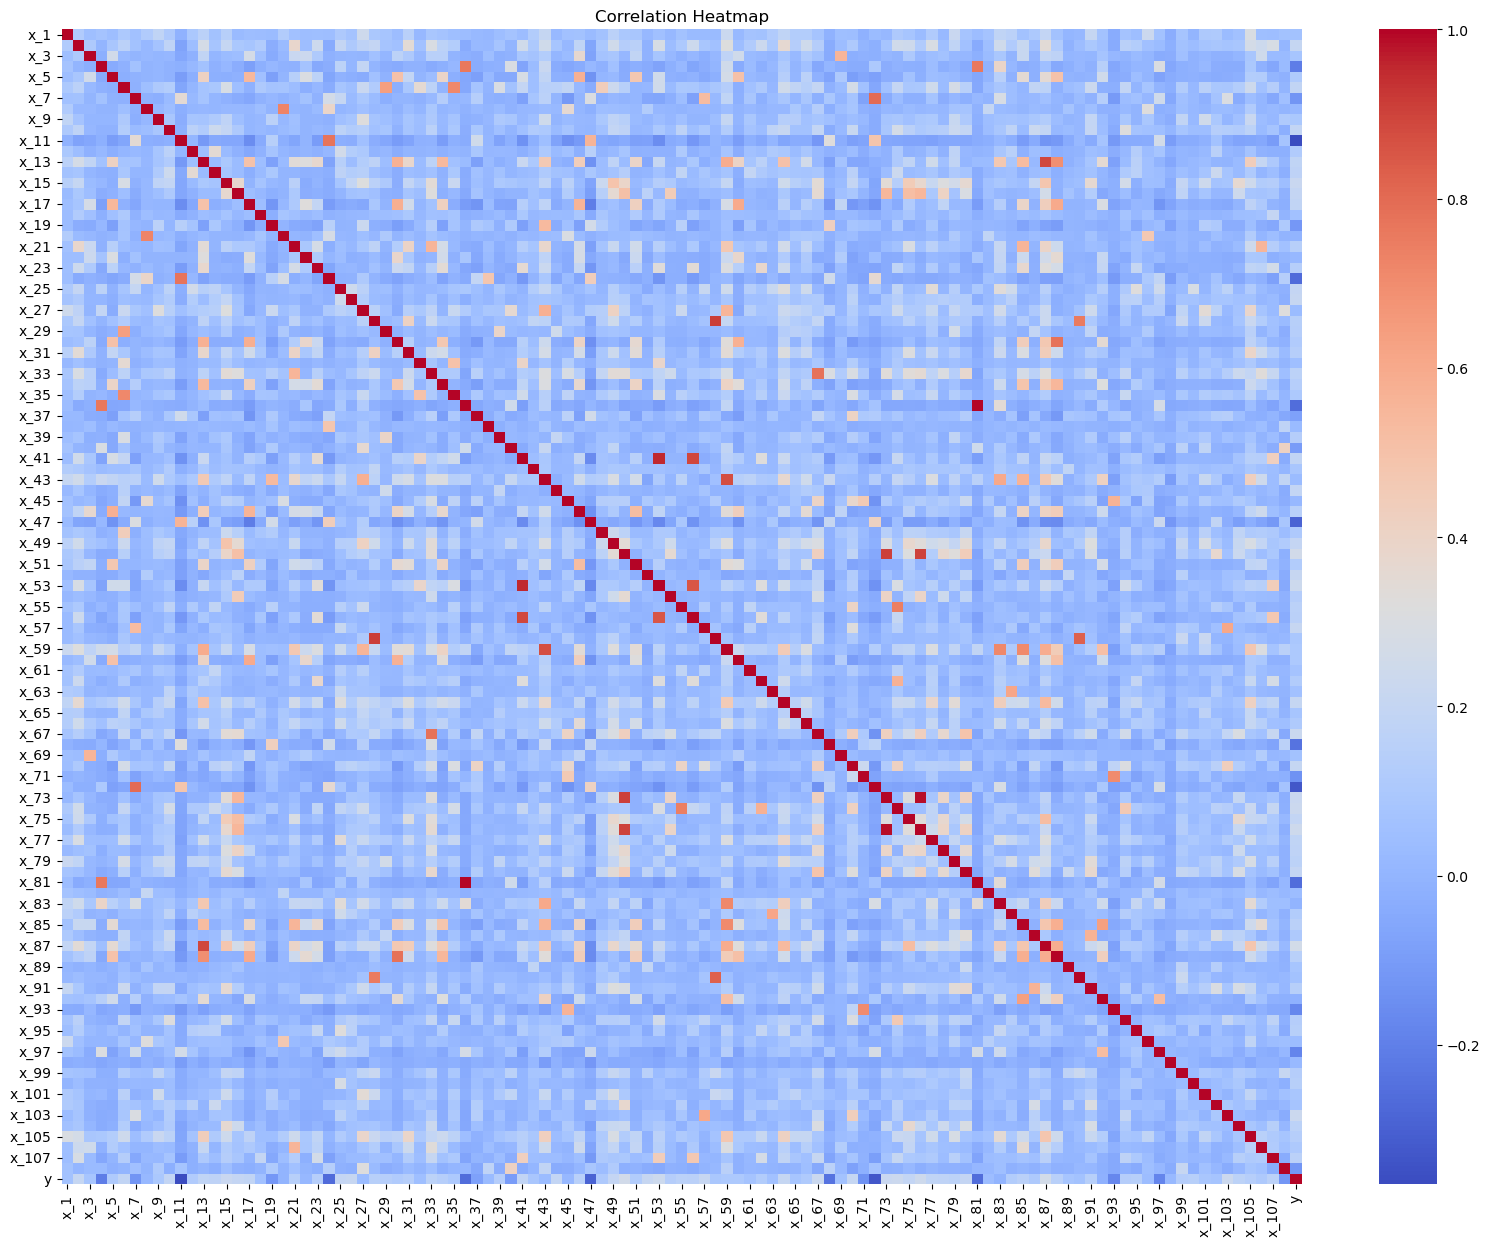

In [5]:
corr_matrix = train_data.corr()

plt.figure(figsize=(20, 15))

sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')

# Set the title
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

## Feature Engineering

### TSNE

In [5]:

X_tsne = TSNE(learning_rate=100).fit_transform(train_data.drop(['y'], axis = 1))
figure(figsize=(10, 5))
scatter(X_tsne[:, 0], X_tsne[:, 1], c=train_data['y'])

NameError: name 'figure' is not defined

In [1]:

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=train_data['y'])

NameError: name 'plt' is not defined

## Decision Tree Model

In [21]:
X = train_data.drop(['y'], axis = 1)
y = train_data['y']
number_f_class = len(y.unique())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 13)
print("number of classes: ", number_f_class)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

number of classes:  9
(50000, 108) (12500, 108) (50000,) (12500,)


In [9]:
model = DecisionTreeClassifier(random_state = 10, max_depth = 25)
model.fit(X_train, y_train)
predicted = model.predict(X_test)
predicted_train = model.predict(X_train)

In [10]:
accuracy_train = accuracy_score(predicted_train, y_train)
accuracy_test = accuracy_score(predicted, y_test)
print(f'Accuracy_train: {accuracy_train}')
print(f'Accuracy_test: {accuracy_test}')


Accuracy_train: 0.9058
Accuracy_test: 0.7252


## LightGBM Model

In [22]:
def objective(trial):
    """
    Objective function to be minimized.
    """
    param = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "num_class": number_f_class,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.LGBMClassifier(**param)
    gbm.fit(X_train, y_train)
    preds = gbm.predict(X_test)
    accuracy_test = accuracy_score(y_test, preds)
    return accuracy_test

In [23]:
sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="lightgbm", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2023-11-11 18:02:37,692] A new study created in memory with name: lightgbm


[LightGBM] [Warning] feature_fraction is set=0.5813995435791038, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5813995435791038
[LightGBM] [Warning] lambda_l1 is set=5.6649755830282306e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.6649755830282306e-05
[LightGBM] [Warning] bagging_fraction is set=0.48805353449026784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48805353449026784
[LightGBM] [Warning] lambda_l2 is set=0.030403280126677572, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.030403280126677572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-11-11 18:02:41,508] Trial 0 finished with value: 0.73568 and parameters: {'lambda_l1': 5.6649755830282306e-05, 'lambda_l2': 0.030403280126677572, 'num_leaves': 2, 'feature_fraction': 0.5813995435791038, 'bagging_fraction': 0.48805353449026784, 'bagging_freq': 1, 'min_child_samples': 22}. Best is trial 0 with value: 0.73568.


[LightGBM] [Warning] feature_fraction is set=0.6515167086419769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6515167086419769
[LightGBM] [Warning] lambda_l1 is set=1.2883876209377052e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2883876209377052e-05
[LightGBM] [Warning] bagging_fraction is set=0.8111317002380557, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8111317002380557
[LightGBM] [Warning] lambda_l2 is set=3.72312200494449e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.72312200494449e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-11-11 18:03:15,230] Trial 1 finished with value: 0.83104 and parameters: {'lambda_l1': 1.2883876209377052e-05, 'lambda_l2': 3.72312200494449e-05, 'num_leaves': 139, 'feature_fraction': 0.6515167086419769, 'bagging_fraction': 0.8111317002380557, 'bagging_freq': 2, 'min_child_samples': 89}. Best is trial 1 with value: 0.83104.


[LightGBM] [Warning] feature_fraction is set=0.735213897067451, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.735213897067451
[LightGBM] [Warning] lambda_l1 is set=1.763958399884789e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.763958399884789e-08
[LightGBM] [Warning] bagging_fraction is set=0.4842321631571403, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4842321631571403
[LightGBM] [Warning] lambda_l2 is set=0.010819509974097813, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010819509974097813
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-11-11 18:03:44,331] Trial 2 finished with value: 0.82792 and parameters: {'lambda_l1': 1.763958399884789e-08, 'lambda_l2': 0.010819509974097813, 'num_leaves': 108, 'feature_fraction': 0.735213897067451, 'bagging_fraction': 0.4842321631571403, 'bagging_freq': 2, 'min_child_samples': 81}. Best is trial 1 with value: 0.83104.


[LightGBM] [Warning] feature_fraction is set=0.9258334913776229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9258334913776229
[LightGBM] [Warning] lambda_l1 is set=5.180291295699627, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.180291295699627
[LightGBM] [Warning] bagging_fraction is set=0.9367639981023084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9367639981023084
[LightGBM] [Warning] lambda_l2 is set=6.6193844201488494e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.6193844201488494e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-11-11 18:04:12,671] Trial 3 finished with value: 0.82104 and parameters: {'lambda_l1': 5.180291295699627, 'lambda_l2': 6.6193844201488494e-06, 'num_leaves': 178, 'feature_fraction': 0.9258334913776229, 'bagging_fraction': 0.9367639981023084, 'bagging_freq': 1, 'min_child_samples': 8}. Best is trial 1 with value: 0.83104.


[LightGBM] [Warning] feature_fraction is set=0.6526645750030313, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6526645750030313
[LightGBM] [Warning] lambda_l1 is set=3.376554594427989e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.376554594427989e-07
[LightGBM] [Warning] bagging_fraction is set=0.9747337180903012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9747337180903012
[LightGBM] [Warning] lambda_l2 is set=0.8003547575557912, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8003547575557912
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-11-11 18:04:27,059] Trial 4 finished with value: 0.81784 and parameters: {'lambda_l1': 3.376554594427989e-07, 'lambda_l2': 0.8003547575557912, 'num_leaves': 27, 'feature_fraction': 0.6526645750030313, 'bagging_fraction': 0.9747337180903012, 'bagging_freq': 4, 'min_child_samples': 71}. Best is trial 1 with value: 0.83104.


[LightGBM] [Warning] feature_fraction is set=0.4109729664065151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4109729664065151
[LightGBM] [Warning] lambda_l1 is set=6.912588094940543e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.912588094940543e-06
[LightGBM] [Warning] bagging_fraction is set=0.8500865889669804, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8500865889669804
[LightGBM] [Warning] lambda_l2 is set=0.015083716080906013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015083716080906013
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-11-11 18:05:16,817] Trial 5 finished with value: 0.83256 and parameters: {'lambda_l1': 6.912588094940543e-06, 'lambda_l2': 0.015083716080906013, 'num_leaves': 214, 'feature_fraction': 0.4109729664065151, 'bagging_fraction': 0.8500865889669804, 'bagging_freq': 7, 'min_child_samples': 76}. Best is trial 5 with value: 0.83256.


[LightGBM] [Warning] feature_fraction is set=0.6687361157055431, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6687361157055431
[LightGBM] [Warning] lambda_l1 is set=3.341919070318744e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.341919070318744e-06
[LightGBM] [Warning] bagging_fraction is set=0.9451573018558573, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9451573018558573
[LightGBM] [Warning] lambda_l2 is set=0.12691529280491062, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12691529280491062
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-11-11 18:05:31,436] Trial 6 finished with value: 0.81656 and parameters: {'lambda_l1': 3.341919070318744e-06, 'lambda_l2': 0.12691529280491062, 'num_leaves': 28, 'feature_fraction': 0.6687361157055431, 'bagging_fraction': 0.9451573018558573, 'bagging_freq': 3, 'min_child_samples': 32}. Best is trial 5 with value: 0.83256.


[LightGBM] [Warning] feature_fraction is set=0.5269768696000354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5269768696000354
[LightGBM] [Warning] lambda_l1 is set=1.4799844388224288e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4799844388224288e-07
[LightGBM] [Warning] bagging_fraction is set=0.5593279956233357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5593279956233357
[LightGBM] [Warning] lambda_l2 is set=1.493834966470408e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.493834966470408e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-11-11 18:06:16,079] Trial 7 finished with value: 0.82584 and parameters: {'lambda_l1': 1.4799844388224288e-07, 'lambda_l2': 1.493834966470408e-08, 'num_leaves': 175, 'feature_fraction': 0.5269768696000354, 'bagging_fraction': 0.5593279956233357, 'bagging_freq': 4, 'min_child_samples': 10}. Best is trial 5 with value: 0.83256.


[LightGBM] [Warning] feature_fraction is set=0.8198550160125587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8198550160125587
[LightGBM] [Warning] lambda_l1 is set=0.0014691239860705116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014691239860705116
[LightGBM] [Warning] bagging_fraction is set=0.46140065729669555, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46140065729669555
[LightGBM] [Warning] lambda_l2 is set=2.091978294467618e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.091978294467618e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-11-11 18:06:54,990] Trial 8 finished with value: 0.82744 and parameters: {'lambda_l1': 0.0014691239860705116, 'lambda_l2': 2.091978294467618e-07, 'num_leaves': 152, 'feature_fraction': 0.8198550160125587, 'bagging_fraction': 0.46140065729669555, 'bagging_freq': 3, 'min_child_samples': 71}. Best is trial 5 with value: 0.83256.


[LightGBM] [Warning] feature_fraction is set=0.7982767871318732, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7982767871318732
[LightGBM] [Warning] lambda_l1 is set=5.340887446119036e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.340887446119036e-05
[LightGBM] [Warning] bagging_fraction is set=0.7089334672349852, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7089334672349852
[LightGBM] [Warning] lambda_l2 is set=2.8156659603215856e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8156659603215856e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-11-11 18:07:32,775] Trial 9 finished with value: 0.82704 and parameters: {'lambda_l1': 5.340887446119036e-05, 'lambda_l2': 2.8156659603215856e-08, 'num_leaves': 138, 'feature_fraction': 0.7982767871318732, 'bagging_fraction': 0.7089334672349852, 'bagging_freq': 7, 'min_child_samples': 61}. Best is trial 5 with value: 0.83256.


[LightGBM] [Warning] feature_fraction is set=0.42363128013079204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42363128013079204
[LightGBM] [Warning] lambda_l1 is set=0.0029522590866082835, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0029522590866082835
[LightGBM] [Warning] bagging_fraction is set=0.7917733264802463, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7917733264802463
[LightGBM] [Warning] lambda_l2 is set=4.826385847167059, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.826385847167059
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-11-11 18:08:15,090] Trial 10 finished with value: 0.82832 and parameters: {'lambda_l1': 0.0029522590866082835, 'lambda_l2': 4.826385847167059, 'num_leaves': 248, 'feature_fraction': 0.42363128013079204, 'bagging_fraction': 0.7917733264802463, 'bagging_freq': 7, 'min_child_samples': 46}. Best is trial 5 with value: 0.83256.


[LightGBM] [Warning] feature_fraction is set=0.4175567281174416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4175567281174416
[LightGBM] [Warning] lambda_l1 is set=1.9379048385844075e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9379048385844075e-06
[LightGBM] [Warning] bagging_fraction is set=0.8264148451314501, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8264148451314501
[LightGBM] [Warning] lambda_l2 is set=0.00013871569811411342, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00013871569811411342
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-11-11 18:09:13,605] Trial 11 finished with value: 0.83136 and parameters: {'lambda_l1': 1.9379048385844075e-06, 'lambda_l2': 0.00013871569811411342, 'num_leaves': 243, 'feature_fraction': 0.4175567281174416, 'bagging_fraction': 0.8264148451314501, 'bagging_freq': 6, 'min_child_samples': 100}. Best is trial 5 with value: 0.83256.


[LightGBM] [Warning] feature_fraction is set=0.42899255539163994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42899255539163994
[LightGBM] [Warning] lambda_l1 is set=1.1603287197276274e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1603287197276274e-06
[LightGBM] [Warning] bagging_fraction is set=0.837133847040843, subsample=1.0 will be ignored. Current value: bagging_fraction=0.837133847040843
[LightGBM] [Warning] lambda_l2 is set=0.0011416554712565673, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011416554712565673
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-11-11 18:10:13,895] Trial 12 finished with value: 0.83152 and parameters: {'lambda_l1': 1.1603287197276274e-06, 'lambda_l2': 0.0011416554712565673, 'num_leaves': 247, 'feature_fraction': 0.42899255539163994, 'bagging_fraction': 0.837133847040843, 'bagging_freq': 6, 'min_child_samples': 98}. Best is trial 5 with value: 0.83256.


[LightGBM] [Warning] feature_fraction is set=0.48857260136110225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48857260136110225
[LightGBM] [Warning] lambda_l1 is set=2.694364336302213e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.694364336302213e-08
[LightGBM] [Warning] bagging_fraction is set=0.8765473800742325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8765473800742325
[LightGBM] [Warning] lambda_l2 is set=0.003116568529076235, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003116568529076235
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-11-11 18:10:35,154] Trial 13 finished with value: 0.83032 and parameters: {'lambda_l1': 2.694364336302213e-08, 'lambda_l2': 0.003116568529076235, 'num_leaves': 212, 'feature_fraction': 0.48857260136110225, 'bagging_fraction': 0.8765473800742325, 'bagging_freq': 6, 'min_child_samples': 100}. Best is trial 5 with value: 0.83256.


[LightGBM] [Warning] feature_fraction is set=0.4052973240522179, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4052973240522179
[LightGBM] [Warning] lambda_l1 is set=1.003918169428895e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.003918169428895e-06
[LightGBM] [Warning] bagging_fraction is set=0.7238491209346329, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7238491209346329
[LightGBM] [Warning] lambda_l2 is set=0.0009904520767959868, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009904520767959868
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-11-11 18:10:47,898] Trial 14 finished with value: 0.82936 and parameters: {'lambda_l1': 1.003918169428895e-06, 'lambda_l2': 0.0009904520767959868, 'num_leaves': 211, 'feature_fraction': 0.4052973240522179, 'bagging_fraction': 0.7238491209346329, 'bagging_freq': 6, 'min_child_samples': 82}. Best is trial 5 with value: 0.83256.


[LightGBM] [Warning] feature_fraction is set=0.5051971888213371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5051971888213371
[LightGBM] [Warning] lambda_l1 is set=0.0002327483120418849, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002327483120418849
[LightGBM] [Warning] bagging_fraction is set=0.8816863705931817, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8816863705931817
[LightGBM] [Warning] lambda_l2 is set=0.000642434399556575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000642434399556575
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-11-11 18:10:58,798] Trial 15 finished with value: 0.82896 and parameters: {'lambda_l1': 0.0002327483120418849, 'lambda_l2': 0.000642434399556575, 'num_leaves': 89, 'feature_fraction': 0.5051971888213371, 'bagging_fraction': 0.8816863705931817, 'bagging_freq': 5, 'min_child_samples': 52}. Best is trial 5 with value: 0.83256.


[LightGBM] [Warning] feature_fraction is set=0.5720548111149261, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5720548111149261
[LightGBM] [Warning] lambda_l1 is set=1.6455691841213074e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6455691841213074e-07
[LightGBM] [Warning] bagging_fraction is set=0.6230390639898935, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6230390639898935
[LightGBM] [Warning] lambda_l2 is set=0.10314276624455435, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10314276624455435
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-11-11 18:11:12,784] Trial 16 finished with value: 0.82824 and parameters: {'lambda_l1': 1.6455691841213074e-07, 'lambda_l2': 0.10314276624455435, 'num_leaves': 218, 'feature_fraction': 0.5720548111149261, 'bagging_fraction': 0.6230390639898935, 'bagging_freq': 7, 'min_child_samples': 91}. Best is trial 5 with value: 0.83256.


[LightGBM] [Warning] feature_fraction is set=0.460330243087531, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.460330243087531
[LightGBM] [Warning] lambda_l1 is set=1.0695144646136052e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0695144646136052e-05
[LightGBM] [Warning] bagging_fraction is set=0.7581790847966424, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7581790847966424
[LightGBM] [Warning] lambda_l2 is set=0.005775639800608074, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005775639800608074
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-11-11 18:11:26,560] Trial 17 finished with value: 0.82696 and parameters: {'lambda_l1': 1.0695144646136052e-05, 'lambda_l2': 0.005775639800608074, 'num_leaves': 188, 'feature_fraction': 0.460330243087531, 'bagging_fraction': 0.7581790847966424, 'bagging_freq': 5, 'min_child_samples': 67}. Best is trial 5 with value: 0.83256.


[LightGBM] [Warning] feature_fraction is set=0.5477918000243716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5477918000243716
[LightGBM] [Warning] lambda_l1 is set=6.687372408934421e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.687372408934421e-07
[LightGBM] [Warning] bagging_fraction is set=0.8716927552664437, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8716927552664437
[LightGBM] [Warning] lambda_l2 is set=0.00012555038396812093, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00012555038396812093
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-11-11 18:11:43,150] Trial 18 finished with value: 0.82984 and parameters: {'lambda_l1': 6.687372408934421e-07, 'lambda_l2': 0.00012555038396812093, 'num_leaves': 252, 'feature_fraction': 0.5477918000243716, 'bagging_fraction': 0.8716927552664437, 'bagging_freq': 5, 'min_child_samples': 79}. Best is trial 5 with value: 0.83256.


[LightGBM] [Warning] feature_fraction is set=0.4648806730205026, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4648806730205026
[LightGBM] [Warning] lambda_l1 is set=1.3300152963059127e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3300152963059127e-08
[LightGBM] [Warning] bagging_fraction is set=0.672706527722958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.672706527722958
[LightGBM] [Warning] lambda_l2 is set=0.029987326674546233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.029987326674546233
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-11-11 18:11:52,012] Trial 19 finished with value: 0.82824 and parameters: {'lambda_l1': 1.3300152963059127e-08, 'lambda_l2': 0.029987326674546233, 'num_leaves': 79, 'feature_fraction': 0.4648806730205026, 'bagging_fraction': 0.672706527722958, 'bagging_freq': 6, 'min_child_samples': 43}. Best is trial 5 with value: 0.83256.


[LightGBM] [Warning] feature_fraction is set=0.5893187108062113, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5893187108062113
[LightGBM] [Warning] lambda_l1 is set=3.013294884910177e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.013294884910177e-06
[LightGBM] [Warning] bagging_fraction is set=0.9894562361647804, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9894562361647804
[LightGBM] [Warning] lambda_l2 is set=0.0016535115232121649, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016535115232121649
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-11-11 18:12:12,927] Trial 20 finished with value: 0.8312 and parameters: {'lambda_l1': 3.013294884910177e-06, 'lambda_l2': 0.0016535115232121649, 'num_leaves': 225, 'feature_fraction': 0.5893187108062113, 'bagging_fraction': 0.9894562361647804, 'bagging_freq': 7, 'min_child_samples': 92}. Best is trial 5 with value: 0.83256.


[LightGBM] [Warning] feature_fraction is set=0.4008528544058448, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4008528544058448
[LightGBM] [Warning] lambda_l1 is set=2.7096421423361544e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7096421423361544e-06
[LightGBM] [Warning] bagging_fraction is set=0.8115164615931691, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8115164615931691
[LightGBM] [Warning] lambda_l2 is set=0.0002531768453066495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002531768453066495
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-11-11 18:12:34,148] Trial 21 finished with value: 0.83096 and parameters: {'lambda_l1': 2.7096421423361544e-06, 'lambda_l2': 0.0002531768453066495, 'num_leaves': 255, 'feature_fraction': 0.4008528544058448, 'bagging_fraction': 0.8115164615931691, 'bagging_freq': 6, 'min_child_samples': 98}. Best is trial 5 with value: 0.83256.


[LightGBM] [Warning] feature_fraction is set=0.4628230685286908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4628230685286908
[LightGBM] [Warning] lambda_l1 is set=3.049523590679175e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.049523590679175e-07
[LightGBM] [Warning] bagging_fraction is set=0.8429611660441773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8429611660441773
[LightGBM] [Warning] lambda_l2 is set=2.6369373415223657e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6369373415223657e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-11-11 18:12:58,939] Trial 22 finished with value: 0.82984 and parameters: {'lambda_l1': 3.049523590679175e-07, 'lambda_l2': 2.6369373415223657e-05, 'num_leaves': 231, 'feature_fraction': 0.4628230685286908, 'bagging_fraction': 0.8429611660441773, 'bagging_freq': 6, 'min_child_samples': 100}. Best is trial 5 with value: 0.83256.


[LightGBM] [Warning] feature_fraction is set=0.44152429119513376, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44152429119513376
[LightGBM] [Warning] lambda_l1 is set=2.3057010630484807e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3057010630484807e-05
[LightGBM] [Warning] bagging_fraction is set=0.9095024881378132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9095024881378132
[LightGBM] [Warning] lambda_l2 is set=0.00028456305119796107, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00028456305119796107
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-11-11 18:13:53,542] Trial 23 finished with value: 0.83128 and parameters: {'lambda_l1': 2.3057010630484807e-05, 'lambda_l2': 0.00028456305119796107, 'num_leaves': 195, 'feature_fraction': 0.44152429119513376, 'bagging_fraction': 0.9095024881378132, 'bagging_freq': 5, 'min_child_samples': 84}. Best is trial 5 with value: 0.83256.


[LightGBM] [Warning] feature_fraction is set=0.5183363269169616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5183363269169616
[LightGBM] [Warning] lambda_l1 is set=5.799527988596815e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.799527988596815e-08
[LightGBM] [Warning] bagging_fraction is set=0.7693358075530563, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7693358075530563
[LightGBM] [Warning] lambda_l2 is set=0.003922385176076947, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003922385176076947
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-11-11 18:14:19,067] Trial 24 finished with value: 0.8312 and parameters: {'lambda_l1': 5.799527988596815e-08, 'lambda_l2': 0.003922385176076947, 'num_leaves': 239, 'feature_fraction': 0.5183363269169616, 'bagging_fraction': 0.7693358075530563, 'bagging_freq': 7, 'min_child_samples': 62}. Best is trial 5 with value: 0.83256.


[LightGBM] [Warning] feature_fraction is set=0.43490027971595735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43490027971595735
[LightGBM] [Warning] lambda_l1 is set=2.32714776577485e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.32714776577485e-06
[LightGBM] [Warning] bagging_fraction is set=0.8349422655196435, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8349422655196435
[LightGBM] [Warning] lambda_l2 is set=2.2399903302167714e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2399903302167714e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-11-11 18:14:40,955] Trial 25 finished with value: 0.82696 and parameters: {'lambda_l1': 2.32714776577485e-06, 'lambda_l2': 2.2399903302167714e-06, 'num_leaves': 161, 'feature_fraction': 0.43490027971595735, 'bagging_fraction': 0.8349422655196435, 'bagging_freq': 6, 'min_child_samples': 75}. Best is trial 5 with value: 0.83256.


[LightGBM] [Warning] feature_fraction is set=0.4047657111960993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4047657111960993
[LightGBM] [Warning] lambda_l1 is set=9.358171256863288e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.358171256863288e-08
[LightGBM] [Warning] bagging_fraction is set=0.7607028554592573, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7607028554592573
[LightGBM] [Warning] lambda_l2 is set=0.0008914837376788306, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008914837376788306
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-11-11 18:15:09,781] Trial 26 finished with value: 0.82896 and parameters: {'lambda_l1': 9.358171256863288e-08, 'lambda_l2': 0.0008914837376788306, 'num_leaves': 203, 'feature_fraction': 0.4047657111960993, 'bagging_fraction': 0.7607028554592573, 'bagging_freq': 5, 'min_child_samples': 90}. Best is trial 5 with value: 0.83256.


[LightGBM] [Warning] feature_fraction is set=0.48748765914956216, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48748765914956216
[LightGBM] [Warning] lambda_l1 is set=4.815694874590332e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.815694874590332e-07
[LightGBM] [Warning] bagging_fraction is set=0.9105118813858761, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9105118813858761
[LightGBM] [Warning] lambda_l2 is set=0.00010391201173019168, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010391201173019168
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-11-11 18:15:28,765] Trial 27 finished with value: 0.82984 and parameters: {'lambda_l1': 4.815694874590332e-07, 'lambda_l2': 0.00010391201173019168, 'num_leaves': 237, 'feature_fraction': 0.48748765914956216, 'bagging_fraction': 0.9105118813858761, 'bagging_freq': 7, 'min_child_samples': 93}. Best is trial 5 with value: 0.83256.


[LightGBM] [Warning] feature_fraction is set=0.4860843129285265, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4860843129285265
[LightGBM] [Warning] lambda_l1 is set=6.504089636538344e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.504089636538344e-06
[LightGBM] [Warning] bagging_fraction is set=0.8365438492914731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8365438492914731
[LightGBM] [Warning] lambda_l2 is set=0.015582192369800765, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015582192369800765
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-11-11 18:16:01,422] Trial 28 finished with value: 0.83296 and parameters: {'lambda_l1': 6.504089636538344e-06, 'lambda_l2': 0.015582192369800765, 'num_leaves': 232, 'feature_fraction': 0.4860843129285265, 'bagging_fraction': 0.8365438492914731, 'bagging_freq': 6, 'min_child_samples': 86}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.5417772706008931, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5417772706008931
[LightGBM] [Warning] lambda_l1 is set=5.713313853962511e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.713313853962511e-05
[LightGBM] [Warning] bagging_fraction is set=0.85911606693137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85911606693137
[LightGBM] [Warning] lambda_l2 is set=0.04298612284105191, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04298612284105191
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-11-11 18:16:23,308] Trial 29 finished with value: 0.832 and parameters: {'lambda_l1': 5.713313853962511e-05, 'lambda_l2': 0.04298612284105191, 'num_leaves': 169, 'feature_fraction': 0.5417772706008931, 'bagging_fraction': 0.85911606693137, 'bagging_freq': 4, 'min_child_samples': 86}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.5957756219120723, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5957756219120723
[LightGBM] [Warning] lambda_l1 is set=9.529130585639377e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.529130585639377e-05
[LightGBM] [Warning] bagging_fraction is set=0.869200097866641, subsample=1.0 will be ignored. Current value: bagging_fraction=0.869200097866641
[LightGBM] [Warning] lambda_l2 is set=0.02876491200890911, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02876491200890911
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-11-11 18:16:44,798] Trial 30 finished with value: 0.8312 and parameters: {'lambda_l1': 9.529130585639377e-05, 'lambda_l2': 0.02876491200890911, 'num_leaves': 118, 'feature_fraction': 0.5957756219120723, 'bagging_fraction': 0.869200097866641, 'bagging_freq': 3, 'min_child_samples': 59}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.48737948110790286, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48737948110790286
[LightGBM] [Warning] lambda_l1 is set=1.157601716389298e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.157601716389298e-05
[LightGBM] [Warning] bagging_fraction is set=0.8420206341633748, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8420206341633748
[LightGBM] [Warning] lambda_l2 is set=0.013160396339855822, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013160396339855822
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-11-11 18:17:13,872] Trial 31 finished with value: 0.8316 and parameters: {'lambda_l1': 1.157601716389298e-05, 'lambda_l2': 0.013160396339855822, 'num_leaves': 192, 'feature_fraction': 0.48737948110790286, 'bagging_fraction': 0.8420206341633748, 'bagging_freq': 4, 'min_child_samples': 84}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.5576604937038814, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5576604937038814
[LightGBM] [Warning] lambda_l1 is set=1.1795023954324503e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1795023954324503e-05
[LightGBM] [Warning] bagging_fraction is set=0.7939340214091171, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7939340214091171
[LightGBM] [Warning] lambda_l2 is set=0.14468945333067829, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14468945333067829
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-11-11 18:17:39,301] Trial 32 finished with value: 0.82824 and parameters: {'lambda_l1': 1.1795023954324503e-05, 'lambda_l2': 0.14468945333067829, 'num_leaves': 171, 'feature_fraction': 0.5576604937038814, 'bagging_fraction': 0.7939340214091171, 'bagging_freq': 4, 'min_child_samples': 85}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.49503476332529606, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49503476332529606
[LightGBM] [Warning] lambda_l1 is set=3.98916134510018e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.98916134510018e-05
[LightGBM] [Warning] bagging_fraction is set=0.9140490728295609, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9140490728295609
[LightGBM] [Warning] lambda_l2 is set=0.012991778161248156, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012991778161248156
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-11-11 18:18:09,357] Trial 33 finished with value: 0.83184 and parameters: {'lambda_l1': 3.98916134510018e-05, 'lambda_l2': 0.012991778161248156, 'num_leaves': 192, 'feature_fraction': 0.49503476332529606, 'bagging_fraction': 0.9140490728295609, 'bagging_freq': 4, 'min_child_samples': 77}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.6127277750375099, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6127277750375099
[LightGBM] [Warning] lambda_l1 is set=5.915497555867215e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.915497555867215e-05
[LightGBM] [Warning] bagging_fraction is set=0.9294826593569978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9294826593569978
[LightGBM] [Warning] lambda_l2 is set=0.012603908518618973, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012603908518618973
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-11-11 18:18:28,008] Trial 34 finished with value: 0.83048 and parameters: {'lambda_l1': 5.915497555867215e-05, 'lambda_l2': 0.012603908518618973, 'num_leaves': 147, 'feature_fraction': 0.6127277750375099, 'bagging_fraction': 0.9294826593569978, 'bagging_freq': 2, 'min_child_samples': 77}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.5325151150176186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5325151150176186
[LightGBM] [Warning] lambda_l1 is set=0.00036737853121012745, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00036737853121012745
[LightGBM] [Warning] bagging_fraction is set=0.9050431324383972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9050431324383972
[LightGBM] [Warning] lambda_l2 is set=0.31630928941833863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.31630928941833863
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-11-11 18:18:55,975] Trial 35 finished with value: 0.83016 and parameters: {'lambda_l1': 0.00036737853121012745, 'lambda_l2': 0.31630928941833863, 'num_leaves': 167, 'feature_fraction': 0.5325151150176186, 'bagging_fraction': 0.9050431324383972, 'bagging_freq': 4, 'min_child_samples': 71}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.6219100555099163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6219100555099163
[LightGBM] [Warning] lambda_l1 is set=7.170052595698863e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.170052595698863e-06
[LightGBM] [Warning] bagging_fraction is set=0.9987749945469565, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9987749945469565
[LightGBM] [Warning] lambda_l2 is set=0.06302369659511979, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06302369659511979
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-11-11 18:19:34,061] Trial 36 finished with value: 0.83112 and parameters: {'lambda_l1': 7.170052595698863e-06, 'lambda_l2': 0.06302369659511979, 'num_leaves': 186, 'feature_fraction': 0.6219100555099163, 'bagging_fraction': 0.9987749945469565, 'bagging_freq': 3, 'min_child_samples': 74}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.5474829229898537, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5474829229898537
[LightGBM] [Warning] lambda_l1 is set=3.591674507119127e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.591674507119127e-05
[LightGBM] [Warning] bagging_fraction is set=0.9605173293462632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9605173293462632
[LightGBM] [Warning] lambda_l2 is set=0.7459824943769371, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7459824943769371
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-11-11 18:20:12,586] Trial 37 finished with value: 0.83216 and parameters: {'lambda_l1': 3.591674507119127e-05, 'lambda_l2': 0.7459824943769371, 'num_leaves': 204, 'feature_fraction': 0.5474829229898537, 'bagging_fraction': 0.9605173293462632, 'bagging_freq': 4, 'min_child_samples': 65}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.5528789183863085, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5528789183863085
[LightGBM] [Warning] lambda_l1 is set=0.00015145344167243519, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00015145344167243519
[LightGBM] [Warning] bagging_fraction is set=0.9565962117943242, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9565962117943242
[LightGBM] [Warning] lambda_l2 is set=0.7810697676443097, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7810697676443097
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-11-11 18:20:40,074] Trial 38 finished with value: 0.83024 and parameters: {'lambda_l1': 0.00015145344167243519, 'lambda_l2': 0.7810697676443097, 'num_leaves': 204, 'feature_fraction': 0.5528789183863085, 'bagging_fraction': 0.9565962117943242, 'bagging_freq': 1, 'min_child_samples': 64}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.6766092306733985, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6766092306733985
[LightGBM] [Warning] lambda_l1 is set=0.000701577738532088, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000701577738532088
[LightGBM] [Warning] bagging_fraction is set=0.9595834895919135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9595834895919135
[LightGBM] [Warning] lambda_l2 is set=2.7251612567158445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7251612567158445
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-11-11 18:21:11,161] Trial 39 finished with value: 0.83128 and parameters: {'lambda_l1': 0.000701577738532088, 'lambda_l2': 2.7251612567158445, 'num_leaves': 222, 'feature_fraction': 0.6766092306733985, 'bagging_fraction': 0.9595834895919135, 'bagging_freq': 3, 'min_child_samples': 55}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.5265096247079498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5265096247079498
[LightGBM] [Warning] lambda_l1 is set=2.622746445153567e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.622746445153567e-05
[LightGBM] [Warning] bagging_fraction is set=0.9523738775259327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9523738775259327
[LightGBM] [Warning] lambda_l2 is set=0.5630144332768781, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5630144332768781
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-11-11 18:21:34,307] Trial 40 finished with value: 0.82992 and parameters: {'lambda_l1': 2.622746445153567e-05, 'lambda_l2': 0.5630144332768781, 'num_leaves': 126, 'feature_fraction': 0.5265096247079498, 'bagging_fraction': 0.9523738775259327, 'bagging_freq': 5, 'min_child_samples': 30}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.5134351544590372, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5134351544590372
[LightGBM] [Warning] lambda_l1 is set=3.9607882191771784e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9607882191771784e-05
[LightGBM] [Warning] bagging_fraction is set=0.9310656104275086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9310656104275086
[LightGBM] [Warning] lambda_l2 is set=0.05572221301205952, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05572221301205952
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-11-11 18:22:06,963] Trial 41 finished with value: 0.82976 and parameters: {'lambda_l1': 3.9607882191771784e-05, 'lambda_l2': 0.05572221301205952, 'num_leaves': 201, 'feature_fraction': 0.5134351544590372, 'bagging_fraction': 0.9310656104275086, 'bagging_freq': 4, 'min_child_samples': 67}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.46260382446438797, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46260382446438797
[LightGBM] [Warning] lambda_l1 is set=0.00014982666995871701, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014982666995871701
[LightGBM] [Warning] bagging_fraction is set=0.9733710541285312, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9733710541285312
[LightGBM] [Warning] lambda_l2 is set=0.30304394617297653, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.30304394617297653
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-11-11 18:22:25,712] Trial 42 finished with value: 0.82752 and parameters: {'lambda_l1': 0.00014982666995871701, 'lambda_l2': 0.30304394617297653, 'num_leaves': 184, 'feature_fraction': 0.46260382446438797, 'bagging_fraction': 0.9733710541285312, 'bagging_freq': 4, 'min_child_samples': 78}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.6313145044179591, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6313145044179591
[LightGBM] [Warning] lambda_l1 is set=4.637638868793872e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.637638868793872e-06
[LightGBM] [Warning] bagging_fraction is set=0.9025030262303099, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9025030262303099
[LightGBM] [Warning] lambda_l2 is set=0.01336858088845037, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01336858088845037
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-11-11 18:22:49,426] Trial 43 finished with value: 0.8316 and parameters: {'lambda_l1': 4.637638868793872e-06, 'lambda_l2': 0.01336858088845037, 'num_leaves': 156, 'feature_fraction': 0.6313145044179591, 'bagging_fraction': 0.9025030262303099, 'bagging_freq': 4, 'min_child_samples': 86}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.5811395471192232, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5811395471192232
[LightGBM] [Warning] lambda_l1 is set=2.8225352278150046e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8225352278150046e-05
[LightGBM] [Warning] bagging_fraction is set=0.8587522208503063, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8587522208503063
[LightGBM] [Warning] lambda_l2 is set=2.8573686141361025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8573686141361025
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-11-11 18:23:13,825] Trial 44 finished with value: 0.83152 and parameters: {'lambda_l1': 2.8225352278150046e-05, 'lambda_l2': 2.8573686141361025, 'num_leaves': 180, 'feature_fraction': 0.5811395471192232, 'bagging_fraction': 0.8587522208503063, 'bagging_freq': 3, 'min_child_samples': 70}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.4937952583486879, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4937952583486879
[LightGBM] [Warning] lambda_l1 is set=0.004446679461280468, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004446679461280468
[LightGBM] [Warning] bagging_fraction is set=0.8888635201888279, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8888635201888279
[LightGBM] [Warning] lambda_l2 is set=9.364290256475767, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.364290256475767
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-11-11 18:23:27,975] Trial 45 finished with value: 0.828 and parameters: {'lambda_l1': 0.004446679461280468, 'lambda_l2': 9.364290256475767, 'num_leaves': 215, 'feature_fraction': 0.4937952583486879, 'bagging_fraction': 0.8888635201888279, 'bagging_freq': 3, 'min_child_samples': 88}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.559680933242951, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.559680933242951
[LightGBM] [Warning] lambda_l1 is set=5.403806922390856e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.403806922390856e-05
[LightGBM] [Warning] bagging_fraction is set=0.9253156007611069, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9253156007611069
[LightGBM] [Warning] lambda_l2 is set=0.029829503469755155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.029829503469755155
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-11-11 18:24:01,112] Trial 46 finished with value: 0.8304 and parameters: {'lambda_l1': 5.403806922390856e-05, 'lambda_l2': 0.029829503469755155, 'num_leaves': 230, 'feature_fraction': 0.559680933242951, 'bagging_fraction': 0.9253156007611069, 'bagging_freq': 4, 'min_child_samples': 80}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.4394492622043588, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4394492622043588
[LightGBM] [Warning] lambda_l1 is set=7.933717424264983e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.933717424264983e-06
[LightGBM] [Warning] bagging_fraction is set=0.810187184938747, subsample=1.0 will be ignored. Current value: bagging_fraction=0.810187184938747
[LightGBM] [Warning] lambda_l2 is set=0.0056748688487610575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0056748688487610575
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-11-11 18:24:25,940] Trial 47 finished with value: 0.8252 and parameters: {'lambda_l1': 7.933717424264983e-06, 'lambda_l2': 0.0056748688487610575, 'num_leaves': 142, 'feature_fraction': 0.4394492622043588, 'bagging_fraction': 0.810187184938747, 'bagging_freq': 5, 'min_child_samples': 57}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.5370560410198625, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5370560410198625
[LightGBM] [Warning] lambda_l1 is set=0.00046598507055980076, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00046598507055980076
[LightGBM] [Warning] bagging_fraction is set=0.8629871678845643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8629871678845643
[LightGBM] [Warning] lambda_l2 is set=0.18193130446154543, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.18193130446154543
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-11-11 18:24:33,656] Trial 48 finished with value: 0.81472 and parameters: {'lambda_l1': 0.00046598507055980076, 'lambda_l2': 0.18193130446154543, 'num_leaves': 24, 'feature_fraction': 0.5370560410198625, 'bagging_fraction': 0.8629871678845643, 'bagging_freq': 2, 'min_child_samples': 50}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.5092928879963271, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5092928879963271
[LightGBM] [Warning] lambda_l1 is set=1.8952394791216432e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8952394791216432e-05
[LightGBM] [Warning] bagging_fraction is set=0.9373532533004384, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9373532533004384
[LightGBM] [Warning] lambda_l2 is set=0.06298810840025068, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06298810840025068
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-11-11 18:24:49,829] Trial 49 finished with value: 0.832 and parameters: {'lambda_l1': 1.8952394791216432e-05, 'lambda_l2': 0.06298810840025068, 'num_leaves': 207, 'feature_fraction': 0.5092928879963271, 'bagging_fraction': 0.9373532533004384, 'bagging_freq': 4, 'min_child_samples': 73}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.47350129350236014, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47350129350236014
[LightGBM] [Warning] lambda_l1 is set=1.047084957966634e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.047084957966634e-06
[LightGBM] [Warning] bagging_fraction is set=0.9457436776185563, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9457436776185563
[LightGBM] [Warning] lambda_l2 is set=0.07391012127337825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07391012127337825
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-11-11 18:25:04,721] Trial 50 finished with value: 0.83088 and parameters: {'lambda_l1': 1.047084957966634e-06, 'lambda_l2': 0.07391012127337825, 'num_leaves': 206, 'feature_fraction': 0.47350129350236014, 'bagging_fraction': 0.9457436776185563, 'bagging_freq': 7, 'min_child_samples': 72}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.5028753266398819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5028753266398819
[LightGBM] [Warning] lambda_l1 is set=1.968688455065029e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.968688455065029e-05
[LightGBM] [Warning] bagging_fraction is set=0.8942225636352008, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8942225636352008
[LightGBM] [Warning] lambda_l2 is set=0.024691586900057207, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.024691586900057207
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-11-11 18:25:22,306] Trial 51 finished with value: 0.83 and parameters: {'lambda_l1': 1.968688455065029e-05, 'lambda_l2': 0.024691586900057207, 'num_leaves': 195, 'feature_fraction': 0.5028753266398819, 'bagging_fraction': 0.8942225636352008, 'bagging_freq': 4, 'min_child_samples': 66}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.449080380104551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.449080380104551
[LightGBM] [Warning] lambda_l1 is set=9.272758722412432e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.272758722412432e-05
[LightGBM] [Warning] bagging_fraction is set=0.9850816906419301, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9850816906419301
[LightGBM] [Warning] lambda_l2 is set=0.0030480773856348823, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0030480773856348823
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-11-11 18:25:37,869] Trial 52 finished with value: 0.83176 and parameters: {'lambda_l1': 9.272758722412432e-05, 'lambda_l2': 0.0030480773856348823, 'num_leaves': 215, 'feature_fraction': 0.449080380104551, 'bagging_fraction': 0.9850816906419301, 'bagging_freq': 4, 'min_child_samples': 80}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.42621223949201864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42621223949201864
[LightGBM] [Warning] lambda_l1 is set=7.4284521230099935e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.4284521230099935e-06
[LightGBM] [Warning] bagging_fraction is set=0.93107737953299, subsample=1.0 will be ignored. Current value: bagging_fraction=0.93107737953299
[LightGBM] [Warning] lambda_l2 is set=0.064748600675302, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.064748600675302
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-11-11 18:25:51,510] Trial 53 finished with value: 0.82992 and parameters: {'lambda_l1': 7.4284521230099935e-06, 'lambda_l2': 0.064748600675302, 'num_leaves': 172, 'feature_fraction': 0.42621223949201864, 'bagging_fraction': 0.93107737953299, 'bagging_freq': 5, 'min_child_samples': 75}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.5112916997938545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5112916997938545
[LightGBM] [Warning] lambda_l1 is set=3.7737243551288277e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7737243551288277e-06
[LightGBM] [Warning] bagging_fraction is set=0.9713638067863468, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9713638067863468
[LightGBM] [Warning] lambda_l2 is set=0.007997810845461114, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007997810845461114
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-11-11 18:26:10,324] Trial 54 finished with value: 0.8296 and parameters: {'lambda_l1': 3.7737243551288277e-06, 'lambda_l2': 0.007997810845461114, 'num_leaves': 225, 'feature_fraction': 0.5112916997938545, 'bagging_fraction': 0.9713638067863468, 'bagging_freq': 3, 'min_child_samples': 83}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.5376594860835975, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5376594860835975
[LightGBM] [Warning] lambda_l1 is set=1.9009599223848964e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9009599223848964e-05
[LightGBM] [Warning] bagging_fraction is set=0.8838004561591917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8838004561591917
[LightGBM] [Warning] lambda_l2 is set=0.2122060112838715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2122060112838715
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-11-11 18:26:43,631] Trial 55 finished with value: 0.83016 and parameters: {'lambda_l1': 1.9009599223848964e-05, 'lambda_l2': 0.2122060112838715, 'num_leaves': 236, 'feature_fraction': 0.5376594860835975, 'bagging_fraction': 0.8838004561591917, 'bagging_freq': 4, 'min_child_samples': 95}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.48482991521094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48482991521094
[LightGBM] [Warning] lambda_l1 is set=5.4039193936375547e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4039193936375547e-05
[LightGBM] [Warning] bagging_fraction is set=0.8588099406565952, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8588099406565952
[LightGBM] [Warning] lambda_l2 is set=0.002593410398122366, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002593410398122366
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-11-11 18:27:03,074] Trial 56 finished with value: 0.8304 and parameters: {'lambda_l1': 5.4039193936375547e-05, 'lambda_l2': 0.002593410398122366, 'num_leaves': 98, 'feature_fraction': 0.48482991521094, 'bagging_fraction': 0.8588099406565952, 'bagging_freq': 5, 'min_child_samples': 68}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.47181387182212825, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47181387182212825
[LightGBM] [Warning] lambda_l1 is set=1.614473084955609e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.614473084955609e-06
[LightGBM] [Warning] bagging_fraction is set=0.9216052368851453, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9216052368851453
[LightGBM] [Warning] lambda_l2 is set=1.217323707388679, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.217323707388679
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-11-11 18:27:19,763] Trial 57 finished with value: 0.83048 and parameters: {'lambda_l1': 1.614473084955609e-06, 'lambda_l2': 1.217323707388679, 'num_leaves': 178, 'feature_fraction': 0.47181387182212825, 'bagging_fraction': 0.9216052368851453, 'bagging_freq': 3, 'min_child_samples': 88}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.5708685774128436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5708685774128436
[LightGBM] [Warning] lambda_l1 is set=0.0002011672905255735, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002011672905255735
[LightGBM] [Warning] bagging_fraction is set=0.9500484086763091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9500484086763091
[LightGBM] [Warning] lambda_l2 is set=0.10819213272408552, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10819213272408552
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-11-11 18:27:30,836] Trial 58 finished with value: 0.82656 and parameters: {'lambda_l1': 0.0002011672905255735, 'lambda_l2': 0.10819213272408552, 'num_leaves': 63, 'feature_fraction': 0.5708685774128436, 'bagging_fraction': 0.9500484086763091, 'bagging_freq': 5, 'min_child_samples': 95}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.41299136748826193, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41299136748826193
[LightGBM] [Warning] lambda_l1 is set=4.260424664009298e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.260424664009298e-06
[LightGBM] [Warning] bagging_fraction is set=0.8203864039070573, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8203864039070573
[LightGBM] [Warning] lambda_l2 is set=0.4721362748616641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4721362748616641
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-11-11 18:27:46,155] Trial 59 finished with value: 0.83104 and parameters: {'lambda_l1': 4.260424664009298e-06, 'lambda_l2': 0.4721362748616641, 'num_leaves': 247, 'feature_fraction': 0.41299136748826193, 'bagging_fraction': 0.8203864039070573, 'bagging_freq': 4, 'min_child_samples': 77}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.44777569077586027, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44777569077586027
[LightGBM] [Warning] lambda_l1 is set=1.5087639764254443e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5087639764254443e-05
[LightGBM] [Warning] bagging_fraction is set=0.9987999716858083, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9987999716858083
[LightGBM] [Warning] lambda_l2 is set=0.017023614552922506, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017023614552922506
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-11-11 18:28:02,707] Trial 60 finished with value: 0.82992 and parameters: {'lambda_l1': 1.5087639764254443e-05, 'lambda_l2': 0.017023614552922506, 'num_leaves': 194, 'feature_fraction': 0.44777569077586027, 'bagging_fraction': 0.9987999716858083, 'bagging_freq': 7, 'min_child_samples': 42}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.44110377162425773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44110377162425773
[LightGBM] [Warning] lambda_l1 is set=7.850869493181548e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.850869493181548e-05
[LightGBM] [Warning] bagging_fraction is set=0.9729470501662526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9729470501662526
[LightGBM] [Warning] lambda_l2 is set=0.0072490214092757995, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0072490214092757995
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-11-11 18:28:21,881] Trial 61 finished with value: 0.83 and parameters: {'lambda_l1': 7.850869493181548e-05, 'lambda_l2': 0.0072490214092757995, 'num_leaves': 216, 'feature_fraction': 0.44110377162425773, 'bagging_fraction': 0.9729470501662526, 'bagging_freq': 4, 'min_child_samples': 81}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.4535929581812706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4535929581812706
[LightGBM] [Warning] lambda_l1 is set=9.445587453025876e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.445587453025876e-05
[LightGBM] [Warning] bagging_fraction is set=0.8959899207139783, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8959899207139783
[LightGBM] [Warning] lambda_l2 is set=0.0026127814036904194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0026127814036904194
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-11-11 18:28:40,285] Trial 62 finished with value: 0.82848 and parameters: {'lambda_l1': 9.445587453025876e-05, 'lambda_l2': 0.0026127814036904194, 'num_leaves': 211, 'feature_fraction': 0.4535929581812706, 'bagging_fraction': 0.8959899207139783, 'bagging_freq': 4, 'min_child_samples': 73}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.5010989674403596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5010989674403596
[LightGBM] [Warning] lambda_l1 is set=3.961463090188524e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.961463090188524e-05
[LightGBM] [Warning] bagging_fraction is set=0.9757763404046426, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9757763404046426
[LightGBM] [Warning] lambda_l2 is set=0.03874085599193412, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03874085599193412
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-11-11 18:28:58,568] Trial 63 finished with value: 0.83016 and parameters: {'lambda_l1': 3.961463090188524e-05, 'lambda_l2': 0.03874085599193412, 'num_leaves': 226, 'feature_fraction': 0.5010989674403596, 'bagging_fraction': 0.9757763404046426, 'bagging_freq': 4, 'min_child_samples': 61}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.4259299074819162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4259299074819162
[LightGBM] [Warning] lambda_l1 is set=1.61594385684007e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.61594385684007e-05
[LightGBM] [Warning] bagging_fraction is set=0.9141433188220757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9141433188220757
[LightGBM] [Warning] lambda_l2 is set=0.004298144226329952, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004298144226329952
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-11-11 18:29:14,357] Trial 64 finished with value: 0.8312 and parameters: {'lambda_l1': 1.61594385684007e-05, 'lambda_l2': 0.004298144226329952, 'num_leaves': 200, 'feature_fraction': 0.4259299074819162, 'bagging_fraction': 0.9141433188220757, 'bagging_freq': 5, 'min_child_samples': 81}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.4786590512185631, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4786590512185631
[LightGBM] [Warning] lambda_l1 is set=0.00010143943815911846, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010143943815911846
[LightGBM] [Warning] bagging_fraction is set=0.8470770191736673, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8470770191736673
[LightGBM] [Warning] lambda_l2 is set=0.0015342110447426694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015342110447426694
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-11-11 18:29:29,667] Trial 65 finished with value: 0.83096 and parameters: {'lambda_l1': 0.00010143943815911846, 'lambda_l2': 0.0015342110447426694, 'num_leaves': 211, 'feature_fraction': 0.4786590512185631, 'bagging_fraction': 0.8470770191736673, 'bagging_freq': 6, 'min_child_samples': 87}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.5146513778376431, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5146513778376431
[LightGBM] [Warning] lambda_l1 is set=5.9568807387903816e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.9568807387903816e-06
[LightGBM] [Warning] bagging_fraction is set=0.940223047394624, subsample=1.0 will be ignored. Current value: bagging_fraction=0.940223047394624
[LightGBM] [Warning] lambda_l2 is set=0.024130266741038048, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.024130266741038048
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-11-11 18:29:55,883] Trial 66 finished with value: 0.83272 and parameters: {'lambda_l1': 5.9568807387903816e-06, 'lambda_l2': 0.024130266741038048, 'num_leaves': 240, 'feature_fraction': 0.5146513778376431, 'bagging_fraction': 0.940223047394624, 'bagging_freq': 4, 'min_child_samples': 78}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.5417597143615457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5417597143615457
[LightGBM] [Warning] lambda_l1 is set=5.741275425066337e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.741275425066337e-06
[LightGBM] [Warning] bagging_fraction is set=0.9382211058731486, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9382211058731486
[LightGBM] [Warning] lambda_l2 is set=0.020204975434747738, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.020204975434747738
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-11-11 18:30:22,090] Trial 67 finished with value: 0.82992 and parameters: {'lambda_l1': 5.741275425066337e-06, 'lambda_l2': 0.020204975434747738, 'num_leaves': 243, 'feature_fraction': 0.5417597143615457, 'bagging_fraction': 0.9382211058731486, 'bagging_freq': 4, 'min_child_samples': 10}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.5201415796844461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5201415796844461
[LightGBM] [Warning] lambda_l1 is set=1.1916872482630987e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1916872482630987e-06
[LightGBM] [Warning] bagging_fraction is set=0.8867149015400455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8867149015400455
[LightGBM] [Warning] lambda_l2 is set=0.10252317801778649, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10252317801778649
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-11-11 18:30:39,846] Trial 68 finished with value: 0.83104 and parameters: {'lambda_l1': 1.1916872482630987e-06, 'lambda_l2': 0.10252317801778649, 'num_leaves': 256, 'feature_fraction': 0.5201415796844461, 'bagging_fraction': 0.8867149015400455, 'bagging_freq': 5, 'min_child_samples': 69}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.5954527186916889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5954527186916889
[LightGBM] [Warning] lambda_l1 is set=2.5614469287790473e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5614469287790473e-06
[LightGBM] [Warning] bagging_fraction is set=0.8686349264921596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8686349264921596
[LightGBM] [Warning] lambda_l2 is set=0.04451368956394925, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04451368956394925
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-11-11 18:30:55,166] Trial 69 finished with value: 0.83184 and parameters: {'lambda_l1': 2.5614469287790473e-06, 'lambda_l2': 0.04451368956394925, 'num_leaves': 231, 'feature_fraction': 0.5954527186916889, 'bagging_fraction': 0.8686349264921596, 'bagging_freq': 3, 'min_child_samples': 64}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.5051229609284684, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5051229609284684
[LightGBM] [Warning] lambda_l1 is set=9.422976871157364e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.422976871157364e-06
[LightGBM] [Warning] bagging_fraction is set=0.9124073176816943, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9124073176816943
[LightGBM] [Warning] lambda_l2 is set=0.009455172371012953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009455172371012953
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-11-11 18:31:13,828] Trial 70 finished with value: 0.83248 and parameters: {'lambda_l1': 9.422976871157364e-06, 'lambda_l2': 0.009455172371012953, 'num_leaves': 235, 'feature_fraction': 0.5051229609284684, 'bagging_fraction': 0.9124073176816943, 'bagging_freq': 3, 'min_child_samples': 76}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.5028430970004061, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5028430970004061
[LightGBM] [Warning] lambda_l1 is set=1.1338826845422846e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1338826845422846e-05
[LightGBM] [Warning] bagging_fraction is set=0.9396395625241671, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9396395625241671
[LightGBM] [Warning] lambda_l2 is set=0.009752507069835019, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009752507069835019
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-11-11 18:31:41,797] Trial 71 finished with value: 0.83048 and parameters: {'lambda_l1': 1.1338826845422846e-05, 'lambda_l2': 0.009752507069835019, 'num_leaves': 238, 'feature_fraction': 0.5028430970004061, 'bagging_fraction': 0.9396395625241671, 'bagging_freq': 2, 'min_child_samples': 76}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.5247900787282774, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5247900787282774
[LightGBM] [Warning] lambda_l1 is set=3.2660189633178154e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2660189633178154e-05
[LightGBM] [Warning] bagging_fraction is set=0.9177509713474254, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9177509713474254
[LightGBM] [Warning] lambda_l2 is set=0.016863200154296543, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.016863200154296543
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-11-11 18:32:04,944] Trial 72 finished with value: 0.8308 and parameters: {'lambda_l1': 3.2660189633178154e-05, 'lambda_l2': 0.016863200154296543, 'num_leaves': 224, 'feature_fraction': 0.5247900787282774, 'bagging_fraction': 0.9177509713474254, 'bagging_freq': 3, 'min_child_samples': 73}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.5520041165163728, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5520041165163728
[LightGBM] [Warning] lambda_l1 is set=6.375678239640531e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.375678239640531e-06
[LightGBM] [Warning] bagging_fraction is set=0.9038796887335615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9038796887335615
[LightGBM] [Warning] lambda_l2 is set=0.04006739023141609, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04006739023141609
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-11-11 18:32:23,490] Trial 73 finished with value: 0.83128 and parameters: {'lambda_l1': 6.375678239640531e-06, 'lambda_l2': 0.04006739023141609, 'num_leaves': 163, 'feature_fraction': 0.5520041165163728, 'bagging_fraction': 0.9038796887335615, 'bagging_freq': 4, 'min_child_samples': 19}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.4713255083469683, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4713255083469683
[LightGBM] [Warning] lambda_l1 is set=1.8266296922764806e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8266296922764806e-06
[LightGBM] [Warning] bagging_fraction is set=0.8735747821958157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8735747821958157
[LightGBM] [Warning] lambda_l2 is set=0.008651449641850582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008651449641850582
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2023-11-11 18:32:43,426] Trial 74 finished with value: 0.83 and parameters: {'lambda_l1': 1.8266296922764806e-06, 'lambda_l2': 0.008651449641850582, 'num_leaves': 248, 'feature_fraction': 0.4713255083469683, 'bagging_fraction': 0.8735747821958157, 'bagging_freq': 6, 'min_child_samples': 83}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.48935153522793884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48935153522793884
[LightGBM] [Warning] lambda_l1 is set=2.7083510647358025e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7083510647358025e-05
[LightGBM] [Warning] bagging_fraction is set=0.9612508508963711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9612508508963711
[LightGBM] [Warning] lambda_l2 is set=0.13143176819576025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13143176819576025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-11-11 18:32:56,062] Trial 75 finished with value: 0.83128 and parameters: {'lambda_l1': 2.7083510647358025e-05, 'lambda_l2': 0.13143176819576025, 'num_leaves': 207, 'feature_fraction': 0.48935153522793884, 'bagging_fraction': 0.9612508508963711, 'bagging_freq': 1, 'min_child_samples': 91}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.5715491594309235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5715491594309235
[LightGBM] [Warning] lambda_l1 is set=1.0354886937714416e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0354886937714416e-05
[LightGBM] [Warning] bagging_fraction is set=0.8299798903472668, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8299798903472668
[LightGBM] [Warning] lambda_l2 is set=0.0006386696369497235, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006386696369497235
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-11-11 18:33:10,138] Trial 76 finished with value: 0.8328 and parameters: {'lambda_l1': 1.0354886937714416e-05, 'lambda_l2': 0.0006386696369497235, 'num_leaves': 190, 'feature_fraction': 0.5715491594309235, 'bagging_fraction': 0.8299798903472668, 'bagging_freq': 3, 'min_child_samples': 85}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.576840436293655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.576840436293655
[LightGBM] [Warning] lambda_l1 is set=7.616012308851559e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.616012308851559e-07
[LightGBM] [Warning] bagging_fraction is set=0.8303503151613519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8303503151613519
[LightGBM] [Warning] lambda_l2 is set=0.0013927338487374845, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013927338487374845
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-11-11 18:33:25,543] Trial 77 finished with value: 0.8308 and parameters: {'lambda_l1': 7.616012308851559e-07, 'lambda_l2': 0.0013927338487374845, 'num_leaves': 218, 'feature_fraction': 0.576840436293655, 'bagging_fraction': 0.8303503151613519, 'bagging_freq': 3, 'min_child_samples': 94}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.5669906533426277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5669906533426277
[LightGBM] [Warning] lambda_l1 is set=4.0099146326039e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0099146326039e-06
[LightGBM] [Warning] bagging_fraction is set=0.847047631509011, subsample=1.0 will be ignored. Current value: bagging_fraction=0.847047631509011
[LightGBM] [Warning] lambda_l2 is set=0.0007031535817781468, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007031535817781468
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-11-11 18:33:39,874] Trial 78 finished with value: 0.83096 and parameters: {'lambda_l1': 4.0099146326039e-06, 'lambda_l2': 0.0007031535817781468, 'num_leaves': 184, 'feature_fraction': 0.5669906533426277, 'bagging_fraction': 0.847047631509011, 'bagging_freq': 2, 'min_child_samples': 90}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.5402487264964961, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5402487264964961
[LightGBM] [Warning] lambda_l1 is set=1.203617909039741e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.203617909039741e-05
[LightGBM] [Warning] bagging_fraction is set=0.7919279170588325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7919279170588325
[LightGBM] [Warning] lambda_l2 is set=0.005068695111673743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005068695111673743
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-11-11 18:33:55,232] Trial 79 finished with value: 0.83192 and parameters: {'lambda_l1': 1.203617909039741e-05, 'lambda_l2': 0.005068695111673743, 'num_leaves': 234, 'feature_fraction': 0.5402487264964961, 'bagging_fraction': 0.7919279170588325, 'bagging_freq': 3, 'min_child_samples': 83}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.5221510377655277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5221510377655277
[LightGBM] [Warning] lambda_l1 is set=2.6121491654195256e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6121491654195256e-06
[LightGBM] [Warning] bagging_fraction is set=0.879403464610581, subsample=1.0 will be ignored. Current value: bagging_fraction=0.879403464610581
[LightGBM] [Warning] lambda_l2 is set=0.02404535472991715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02404535472991715
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-11-11 18:34:11,881] Trial 80 finished with value: 0.83208 and parameters: {'lambda_l1': 2.6121491654195256e-06, 'lambda_l2': 0.02404535472991715, 'num_leaves': 244, 'feature_fraction': 0.5221510377655277, 'bagging_fraction': 0.879403464610581, 'bagging_freq': 3, 'min_child_samples': 79}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.5057271009454171, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5057271009454171
[LightGBM] [Warning] lambda_l1 is set=8.116711188138025e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.116711188138025e-06
[LightGBM] [Warning] bagging_fraction is set=0.8880555976204214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8880555976204214
[LightGBM] [Warning] lambda_l2 is set=0.02258611568877862, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02258611568877862
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-11-11 18:34:28,221] Trial 81 finished with value: 0.82984 and parameters: {'lambda_l1': 8.116711188138025e-06, 'lambda_l2': 0.02258611568877862, 'num_leaves': 246, 'feature_fraction': 0.5057271009454171, 'bagging_fraction': 0.8880555976204214, 'bagging_freq': 3, 'min_child_samples': 79}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.5538988423702245, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5538988423702245
[LightGBM] [Warning] lambda_l1 is set=3.297883622395036e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.297883622395036e-06
[LightGBM] [Warning] bagging_fraction is set=0.8558757486126879, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8558757486126879
[LightGBM] [Warning] lambda_l2 is set=0.06906392787178646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06906392787178646
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-11-11 18:34:43,436] Trial 82 finished with value: 0.83192 and parameters: {'lambda_l1': 3.297883622395036e-06, 'lambda_l2': 0.06906392787178646, 'num_leaves': 222, 'feature_fraction': 0.5538988423702245, 'bagging_fraction': 0.8558757486126879, 'bagging_freq': 3, 'min_child_samples': 74}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.5192483770245431, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5192483770245431
[LightGBM] [Warning] lambda_l1 is set=2.5548892271702107e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5548892271702107e-06
[LightGBM] [Warning] bagging_fraction is set=0.8085686646128772, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8085686646128772
[LightGBM] [Warning] lambda_l2 is set=0.03167694219028322, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03167694219028322
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-11-11 18:34:59,958] Trial 83 finished with value: 0.82864 and parameters: {'lambda_l1': 2.5548892271702107e-06, 'lambda_l2': 0.03167694219028322, 'num_leaves': 252, 'feature_fraction': 0.5192483770245431, 'bagging_fraction': 0.8085686646128772, 'bagging_freq': 2, 'min_child_samples': 86}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.5279277296688937, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5279277296688937
[LightGBM] [Warning] lambda_l1 is set=1.681086535442464e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.681086535442464e-05
[LightGBM] [Warning] bagging_fraction is set=0.8283072315012933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8283072315012933
[LightGBM] [Warning] lambda_l2 is set=0.19982410181565508, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19982410181565508
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-11-11 18:35:15,519] Trial 84 finished with value: 0.8292 and parameters: {'lambda_l1': 1.681086535442464e-05, 'lambda_l2': 0.19982410181565508, 'num_leaves': 239, 'feature_fraction': 0.5279277296688937, 'bagging_fraction': 0.8283072315012933, 'bagging_freq': 7, 'min_child_samples': 70}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.4602400911910549, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4602400911910549
[LightGBM] [Warning] lambda_l1 is set=1.5018093992264249e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5018093992264249e-06
[LightGBM] [Warning] bagging_fraction is set=0.8781027619756779, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8781027619756779
[LightGBM] [Warning] lambda_l2 is set=0.0004475012780963969, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004475012780963969
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-11-11 18:35:31,139] Trial 85 finished with value: 0.8284 and parameters: {'lambda_l1': 1.5018093992264249e-06, 'lambda_l2': 0.0004475012780963969, 'num_leaves': 230, 'feature_fraction': 0.4602400911910549, 'bagging_fraction': 0.8781027619756779, 'bagging_freq': 3, 'min_child_samples': 65}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.5847339263672736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5847339263672736
[LightGBM] [Warning] lambda_l1 is set=5.891116414811357e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.891116414811357e-07
[LightGBM] [Warning] bagging_fraction is set=0.9010968290810369, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9010968290810369
[LightGBM] [Warning] lambda_l2 is set=0.009873413831336931, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009873413831336931
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-11-11 18:35:46,465] Trial 86 finished with value: 0.83024 and parameters: {'lambda_l1': 5.891116414811357e-07, 'lambda_l2': 0.009873413831336931, 'num_leaves': 208, 'feature_fraction': 0.5847339263672736, 'bagging_fraction': 0.9010968290810369, 'bagging_freq': 4, 'min_child_samples': 78}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.5611977545973065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5611977545973065
[LightGBM] [Warning] lambda_l1 is set=9.216279868991002e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.216279868991002e-06
[LightGBM] [Warning] bagging_fraction is set=0.9415134236787482, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9415134236787482
[LightGBM] [Warning] lambda_l2 is set=0.01769444914031883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01769444914031883
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-11-11 18:36:03,288] Trial 87 finished with value: 0.83128 and parameters: {'lambda_l1': 9.216279868991002e-06, 'lambda_l2': 0.01769444914031883, 'num_leaves': 220, 'feature_fraction': 0.5611977545973065, 'bagging_fraction': 0.9415134236787482, 'bagging_freq': 3, 'min_child_samples': 85}. Best is trial 28 with value: 0.83296.


[LightGBM] [Warning] feature_fraction is set=0.606773610653303, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.606773610653303
[LightGBM] [Warning] lambda_l1 is set=5.117571145089835e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.117571145089835e-06
[LightGBM] [Warning] bagging_fraction is set=0.8462643326394661, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8462643326394661
[LightGBM] [Warning] lambda_l2 is set=0.08753895882464374, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08753895882464374
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-11-11 18:36:17,585] Trial 88 finished with value: 0.834 and parameters: {'lambda_l1': 5.117571145089835e-06, 'lambda_l2': 0.08753895882464374, 'num_leaves': 199, 'feature_fraction': 0.606773610653303, 'bagging_fraction': 0.8462643326394661, 'bagging_freq': 2, 'min_child_samples': 89}. Best is trial 88 with value: 0.834.


[LightGBM] [Warning] feature_fraction is set=0.5899832316989416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5899832316989416
[LightGBM] [Warning] lambda_l1 is set=4.974624678323072e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.974624678323072e-06
[LightGBM] [Warning] bagging_fraction is set=0.8499264140144958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8499264140144958
[LightGBM] [Warning] lambda_l2 is set=0.004934527815203677, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004934527815203677
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-11-11 18:36:30,722] Trial 89 finished with value: 0.8332 and parameters: {'lambda_l1': 4.974624678323072e-06, 'lambda_l2': 0.004934527815203677, 'num_leaves': 199, 'feature_fraction': 0.5899832316989416, 'bagging_fraction': 0.8499264140144958, 'bagging_freq': 1, 'min_child_samples': 90}. Best is trial 88 with value: 0.834.


[LightGBM] [Warning] feature_fraction is set=0.602511542707814, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.602511542707814
[LightGBM] [Warning] lambda_l1 is set=3.1700899374990744e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1700899374990744e-07
[LightGBM] [Warning] bagging_fraction is set=0.8427126403321621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8427126403321621
[LightGBM] [Warning] lambda_l2 is set=0.005061664515994096, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005061664515994096
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-11-11 18:36:42,989] Trial 90 finished with value: 0.83296 and parameters: {'lambda_l1': 3.1700899374990744e-07, 'lambda_l2': 0.005061664515994096, 'num_leaves': 196, 'feature_fraction': 0.602511542707814, 'bagging_fraction': 0.8427126403321621, 'bagging_freq': 1, 'min_child_samples': 96}. Best is trial 88 with value: 0.834.


[LightGBM] [Warning] feature_fraction is set=0.6011595317679443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6011595317679443
[LightGBM] [Warning] lambda_l1 is set=4.3149758888053406e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.3149758888053406e-07
[LightGBM] [Warning] bagging_fraction is set=0.8450485952419786, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8450485952419786
[LightGBM] [Warning] lambda_l2 is set=0.004018524850012295, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004018524850012295
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-11-11 18:36:57,846] Trial 91 finished with value: 0.83192 and parameters: {'lambda_l1': 4.3149758888053406e-07, 'lambda_l2': 0.004018524850012295, 'num_leaves': 201, 'feature_fraction': 0.6011595317679443, 'bagging_fraction': 0.8450485952419786, 'bagging_freq': 1, 'min_child_samples': 99}. Best is trial 88 with value: 0.834.


[LightGBM] [Warning] feature_fraction is set=0.6147814120074989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6147814120074989
[LightGBM] [Warning] lambda_l1 is set=5.1783922514373724e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.1783922514373724e-06
[LightGBM] [Warning] bagging_fraction is set=0.7779127538861573, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7779127538861573
[LightGBM] [Warning] lambda_l2 is set=0.002185853982570811, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002185853982570811
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-11-11 18:37:10,208] Trial 92 finished with value: 0.832 and parameters: {'lambda_l1': 5.1783922514373724e-06, 'lambda_l2': 0.002185853982570811, 'num_leaves': 187, 'feature_fraction': 0.6147814120074989, 'bagging_fraction': 0.7779127538861573, 'bagging_freq': 1, 'min_child_samples': 96}. Best is trial 88 with value: 0.834.


[LightGBM] [Warning] feature_fraction is set=0.6332831768849718, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6332831768849718
[LightGBM] [Warning] lambda_l1 is set=2.6393209558153035e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6393209558153035e-07
[LightGBM] [Warning] bagging_fraction is set=0.8190881087307839, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8190881087307839
[LightGBM] [Warning] lambda_l2 is set=0.007420410495706536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007420410495706536
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-11-11 18:37:23,716] Trial 93 finished with value: 0.8296 and parameters: {'lambda_l1': 2.6393209558153035e-07, 'lambda_l2': 0.007420410495706536, 'num_leaves': 229, 'feature_fraction': 0.6332831768849718, 'bagging_fraction': 0.8190881087307839, 'bagging_freq': 2, 'min_child_samples': 89}. Best is trial 88 with value: 0.834.


[LightGBM] [Warning] feature_fraction is set=0.5854737454934298, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5854737454934298
[LightGBM] [Warning] lambda_l1 is set=1.985863029622915e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.985863029622915e-06
[LightGBM] [Warning] bagging_fraction is set=0.8371986069925693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8371986069925693
[LightGBM] [Warning] lambda_l2 is set=0.0009022821724738798, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009022821724738798
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-11-11 18:37:36,153] Trial 94 finished with value: 0.83304 and parameters: {'lambda_l1': 1.985863029622915e-06, 'lambda_l2': 0.0009022821724738798, 'num_leaves': 216, 'feature_fraction': 0.5854737454934298, 'bagging_fraction': 0.8371986069925693, 'bagging_freq': 1, 'min_child_samples': 91}. Best is trial 88 with value: 0.834.


[LightGBM] [Warning] feature_fraction is set=0.6023814811171738, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6023814811171738
[LightGBM] [Warning] lambda_l1 is set=7.377363804859357e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.377363804859357e-07
[LightGBM] [Warning] bagging_fraction is set=0.8360738462669015, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8360738462669015
[LightGBM] [Warning] lambda_l2 is set=0.0010707277539658982, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010707277539658982
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-11-11 18:37:47,863] Trial 95 finished with value: 0.8308 and parameters: {'lambda_l1': 7.377363804859357e-07, 'lambda_l2': 0.0010707277539658982, 'num_leaves': 199, 'feature_fraction': 0.6023814811171738, 'bagging_fraction': 0.8360738462669015, 'bagging_freq': 1, 'min_child_samples': 92}. Best is trial 88 with value: 0.834.


[LightGBM] [Warning] feature_fraction is set=0.5843371184787763, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5843371184787763
[LightGBM] [Warning] lambda_l1 is set=1.1242613446004256e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1242613446004256e-06
[LightGBM] [Warning] bagging_fraction is set=0.8515555952850076, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8515555952850076
[LightGBM] [Warning] lambda_l2 is set=0.0023086646236338184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0023086646236338184
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-11-11 18:38:00,370] Trial 96 finished with value: 0.83096 and parameters: {'lambda_l1': 1.1242613446004256e-06, 'lambda_l2': 0.0023086646236338184, 'num_leaves': 194, 'feature_fraction': 0.5843371184787763, 'bagging_fraction': 0.8515555952850076, 'bagging_freq': 1, 'min_child_samples': 97}. Best is trial 88 with value: 0.834.


[LightGBM] [Warning] feature_fraction is set=0.5702859273059621, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5702859273059621
[LightGBM] [Warning] lambda_l1 is set=1.7176499297317556e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7176499297317556e-06
[LightGBM] [Warning] bagging_fraction is set=0.8671862689968822, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8671862689968822
[LightGBM] [Warning] lambda_l2 is set=0.0005037715328509848, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005037715328509848
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-11-11 18:38:12,663] Trial 97 finished with value: 0.83392 and parameters: {'lambda_l1': 1.7176499297317556e-06, 'lambda_l2': 0.0005037715328509848, 'num_leaves': 178, 'feature_fraction': 0.5702859273059621, 'bagging_fraction': 0.8671862689968822, 'bagging_freq': 1, 'min_child_samples': 89}. Best is trial 88 with value: 0.834.


[LightGBM] [Warning] feature_fraction is set=0.647941187681265, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.647941187681265
[LightGBM] [Warning] lambda_l1 is set=1.7991604800762506e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7991604800762506e-06
[LightGBM] [Warning] bagging_fraction is set=0.8150894638151924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8150894638151924
[LightGBM] [Warning] lambda_l2 is set=0.00046509357387192825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00046509357387192825
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-11-11 18:38:23,258] Trial 98 finished with value: 0.83056 and parameters: {'lambda_l1': 1.7991604800762506e-06, 'lambda_l2': 0.00046509357387192825, 'num_leaves': 189, 'feature_fraction': 0.647941187681265, 'bagging_fraction': 0.8150894638151924, 'bagging_freq': 1, 'min_child_samples': 89}. Best is trial 88 with value: 0.834.


[LightGBM] [Warning] feature_fraction is set=0.5791238419903681, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5791238419903681
[LightGBM] [Warning] lambda_l1 is set=8.071385459330233e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.071385459330233e-07
[LightGBM] [Warning] bagging_fraction is set=0.8005734735777174, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8005734735777174
[LightGBM] [Warning] lambda_l2 is set=0.00022328907293740454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00022328907293740454
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-11-11 18:38:35,926] Trial 99 finished with value: 0.83184 and parameters: {'lambda_l1': 8.071385459330233e-07, 'lambda_l2': 0.00022328907293740454, 'num_leaves': 178, 'feature_fraction': 0.5791238419903681, 'bagging_fraction': 0.8005734735777174, 'bagging_freq': 1, 'min_child_samples': 94}. Best is trial 88 with value: 0.834.


In [24]:
print('Best parameters:', study.best_params)
print('Best value:', study.best_value)
print('Best trial:', study.best_trial)

Best parameters: {'lambda_l1': 5.117571145089835e-06, 'lambda_l2': 0.08753895882464374, 'num_leaves': 199, 'feature_fraction': 0.606773610653303, 'bagging_fraction': 0.8462643326394661, 'bagging_freq': 2, 'min_child_samples': 89}
Best value: 0.834
Best trial: FrozenTrial(number=88, state=TrialState.COMPLETE, values=[0.834], datetime_start=datetime.datetime(2023, 11, 11, 18, 36, 3, 289516), datetime_complete=datetime.datetime(2023, 11, 11, 18, 36, 17, 585252), params={'lambda_l1': 5.117571145089835e-06, 'lambda_l2': 0.08753895882464374, 'num_leaves': 199, 'feature_fraction': 0.606773610653303, 'bagging_fraction': 0.8462643326394661, 'bagging_freq': 2, 'min_child_samples': 89}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lambda_l1': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'lambda_l2': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'num_leaves': IntDistribution(high=256, log=False, low=2, step=1), 'feature_fraction': FloatDi

In [ ]:
model = lgb.LGBMClassifier(**study.best_params)
model.fit(X_train, y_train)

In [18]:


lgb_model = lgb.LGBMClassifier(max_depth = 20, random_state = 10 )
lgb_model.fit(X_train, y_train)
lgb_acc_test = accuracy_score(y_test, lgb_model.predict(X_test))
lgb_acc_train = accuracy_score(y_train, lgb_model.predict(X_train))
print(f'Accuracy_train_lgb: {lgb_acc_train}')
print(f'Accuracy_test_lgb: {lgb_acc_test}')
print(classification_report(y_test, predicted))



Accuracy_train_lgb: 0.88686
Accuracy_test_lgb: 0.81808
              precision    recall  f1-score   support

           1       0.28      0.44      0.34       380
           2       0.70      0.76      0.73      3320
           3       0.50      0.46      0.48      1598
           4       0.53      0.40      0.46       553
           5       0.96      0.94      0.95       552
           6       0.91      0.91      0.91      2935
           7       0.52      0.41      0.46       542
           8       0.84      0.80      0.82      1630
           9       0.74      0.69      0.71       990

    accuracy                           0.73     12500
   macro avg       0.66      0.65      0.65     12500
weighted avg       0.73      0.73      0.72     12500



In [19]:
print(model.feature_importances_)

[0.00183886 0.00287428 0.00187997 0.00560923 0.00014278 0.00313246
 0.00676519 0.01522094 0.00184234 0.00288005 0.04619127 0.00907794
 0.00409414 0.00306626 0.00215261 0.03481173 0.08277721 0.00084703
 0.01430054 0.00083695 0.0058883  0.00280326 0.01245659 0.00701483
 0.01762227 0.00341795 0.00359264 0.00400087 0.009093   0.00151632
 0.00139221 0.00054098 0.0083129  0.0005539  0.00167134 0.00345557
 0.01646711 0.00501026 0.0042887  0.00495989 0.12715101 0.00144156
 0.00822337 0.01664554 0.01498165 0.00162774 0.01494102 0.00292175
 0.00276374 0.01245839 0.00056277 0.01101508 0.00250037 0.00231407
 0.00521758 0.00367247 0.0095252  0.02539614 0.00526785 0.00222111
 0.00080327 0.01857202 0.00421131 0.00261613 0.00127509 0.0034541
 0.00823805 0.00799757 0.00306092 0.01657831 0.01171003 0.01433093
 0.00964932 0.01928516 0.00127744 0.01675398 0.00342382 0.0035905
 0.00188804 0.00379237 0.04104618 0.0003224  0.00642379 0.00315472
 0.00188713 0.00789919 0.00477782 0.00121749 0.00326338 0.002086

In [20]:
classes = [str(x) for x in train_data['y'].unique().tolist()]
fig = plt.figure(figsize = (20, ))
_ = tree.plot_tree(model, feature_names = X.columns.values.tolist(),
              class_names = classes, filled = True)
fig.savefig("decision_tree.png")

TypeError: from_bounds() missing 1 required positional argument: 'height'